In [10]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
#reading freesurfer results
out_dir = Path("/output")
fig_dir = out_dir / "figs"
fsdata_file = out_dir / 'freesurfer_out_preped.csv'
GROUPS  = ['PD','ET','NC']
tab_data = pd.read_csv(fsdata_file, sep=',', header=0, index_col=0);


#excluding list
tab_data=tab_data.drop(index='sub_0064'); # super large head normal control, NC
tab_data=tab_data.drop(index='sub_0073'); # only left brain NC
# distribution of large brain parts ratio
drop_col_list = ['Left_WM_hypointensities', 'Right_WM_hypointensities', '5th_Ventricle'];
tab_data=tab_data.drop(columns=drop_col_list);
for x in GROUPS:
    print(x , len(tab_data[tab_data["diagnosis"]==x]))

PD 43
ET 38
NC 32


In [11]:
# prepare target data
g_var_list = ['age', 'sex', 'diagnosis', 'eTIV'];
s_var_list  = ['BrainSegVol','CSF','CerebralWhiteMatterVol','CortexVol', 'Brain_Stem', 'SubCortGrayVol', 'TotalGrayVol',
               'CC_Anterior','CC_Mid_Anterior','CC_Central','CC_Mid_Posterior','CC_Posterior',
               '3rd_Ventricle','4th_Ventricle','SupraTentorialVol'];
lr_var_list = ['Cerebellum_Cortex','Cerebellum_White_Matter',
               'Accumbens_area', 'Amygdala','Hippocampus',
               'Caudate', 'Pallidum', 'Putamen', 'Thalamus_Proper', 
               'Inf_Lat_Vent','Lateral_Ventricle'];
def sum_lr(data, var_list):
    item_left   = [ "Left_"+x  for x in var_list];
    item_right  = [ "Right_"+x for x in var_list];
    for x in var_list:
        data[x] = data['Left_'+x]+ data['Right_'+x];
    return data, var_list+item_left+item_right
curr_data, curr_lr_list = sum_lr(tab_data, lr_var_list);

In [12]:
def ctr_conf(data, ctr_var, y_var, method_name):
    from sklearn import linear_model
    import numpy as np
    dat = data.copy(); n_all = dat.shape[0];
    if method_name == 'dpa': # direct proportion adjustment
        new_col=[];
        for x in y_var:
            r_name = x+'_r'; new_col.append(r_name);
            dat[r_name] = dat[x]/dat[ctr_var];
        return dat, new_col
    if method_name == 'rm_norm': #residual based on nc
        nc_data = dat[dat['diagnosis'] == 'NC']; n_nc = nc_data.shape[0]; 
        x_nc = np.hstack((np.ones((n_nc,1)),  np.array(nc_data[ctr_var]))); 
        x_all= np.hstack((np.ones((n_all,1)), np.array(dat[ctr_var])));
        reg_list = []; new_col=[];
        for x in y_var:
            reg = linear_model.LinearRegression()
            y_nc= np.array(nc_data[x]);
            reg.fit(x_nc, y_nc);
            tmp_col = x+"_rm_norm"
            dat[tmp_col] = dat[x]-np.matmul(x_all[:,1:], reg.coef_[1:])
            dat[tmp_col+"_rm_norm_resid"] = dat[x]-reg.predict(x_all)
            dat[tmp_col+"_rm_norm_resid_per"] = (dat[x]-reg.predict(x_all))/dat[x]
            reg_list.append(reg); new_col.append(tmp_col);
        return dat, new_col, reg_list 
    if method_name == 'pcp': # power_corrected_portion
        reg_list = []; new_col=[];
        for x in y_var:
            reg = linear_model.LinearRegression()
            y = np.log(np.array(dat[x]));
            log_eTIV = np.log(np.array(dat['eTIV']));
            x_mat = np.hstack((np.ones((n_all, 1)), np.reshape(log_eTIV, [n_all, 1])))
            reg.fit(x_mat, y);
            tmp_col = x + "_pcp";
            dat[tmp_col] = dat[x]/np.power(curr_data['eTIV'],reg.coef_[1])
            reg_list.append(reg); new_col.append(tmp_col);
        return dat, new_col, reg_list 
    if method_name == 'asc': # allometric scaling coefficient (ASC)
        reg_list = []; new_col=[];
        for x in y_var:
            reg = linear_model.LinearRegression()
            y = np.log10(np.array(dat[x]));
            log_eTIV = np.log10(np.array(dat['eTIV']));
            x_mat = np.hstack((np.ones((n_all, 1)), np.reshape(log_eTIV, [n_all, 1])))
            reg.fit(x_mat, y);
            tmp_col = x + "_asc";
            dat[tmp_col] = dat[x]/np.power(curr_data['eTIV'],reg.coef_[1])
            reg_list.append(reg); new_col.append(tmp_col);
        return dat, new_col, reg_list 
        pass
    if method_name == 'wdcr':# whole dataset confound regression
        pass
    if method_name == 'propensity_score_matching':# whole dataset confound regression
        pass
    if method_name == 'ipsw':# whole dataset confound regression
        pass
    if method_name == 'counter_balancing':# whole dataset confound regression
        pass
    else:
        print([method_name, ' not supported...'])
        return data,[],[]
    return
target_list = ['CSF','CerebralWhiteMatterVol','CortexVol', 'TotalGrayVol',
               'Brain_Stem', 'SubCortGrayVol', 
               'Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
               'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
               'Cerebellum_Cortex','Cerebellum_White_Matter'];

In [13]:
curr_data, rm_norm_list, rm_norm_reg = ctr_conf(curr_data, 
                                              ['age', 'is_Male', 'eTIV'], target_list, 'rm_norm');
curr_data, pcp_list, pcp_reg = ctr_conf(curr_data, 
                                              ['age', 'is_Male', 'eTIV'], target_list, 'pcp');
curr_data, dpa_list = ctr_conf(curr_data, 'eTIV', target_list, 'dpa');

In [14]:
curr_data[curr_data['Cerebellum_Cortex_r']>0.1]
#max(curr_data['Cerebellum_Cortex_r']) # sub_0073
def peep_sub(data, sub_name, features):
    print(sub_name,': ')
    for x in features:
        print('\t' ,x, ': ', data.loc[sub_name, x])
        
peep_sub(curr_data, 'sub_0027', [ 'eTIV', 'Cerebellum_Cortex', 'Cerebellum_Cortex_r'])
peep_sub(curr_data, 'sub_0012', [ 'eTIV', 'Cerebellum_Cortex', 'Cerebellum_Cortex_r'])

sub_0027 : 
	 eTIV :  1678632.04462
	 Cerebellum_Cortex :  91251.79999999999
	 Cerebellum_Cortex_r :  0.05436081140739637
sub_0012 : 
	 eTIV :  1323749.89026
	 Cerebellum_Cortex :  119750.2
	 Cerebellum_Cortex_r :  0.09046285924637898


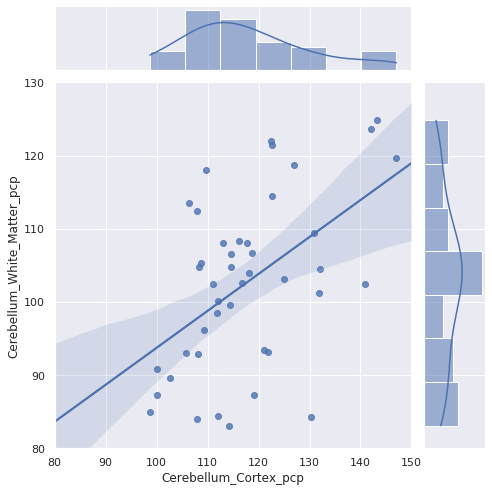

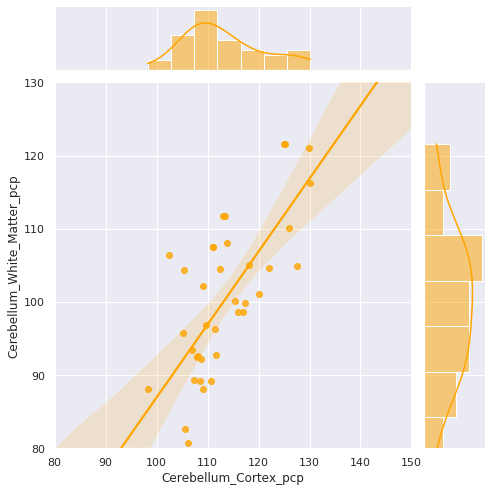

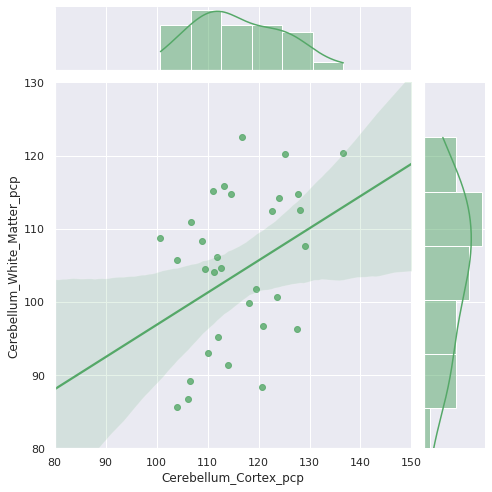

In [22]:
sns.set_theme(style="darkgrid")
g = sns.jointplot(x='Cerebellum_Cortex_pcp', y='Cerebellum_White_Matter_pcp', 
                  data=curr_data[curr_data['diagnosis']=='PD'], xlim=(80, 150), ylim=(80, 130),
                  kind="reg", truncate=False, color="b", height=7)
g = sns.jointplot(x='Cerebellum_Cortex_pcp', y='Cerebellum_White_Matter_pcp', 
                  data=curr_data[curr_data['diagnosis']=='ET'], xlim=(80, 150), ylim=(80, 130),
                  kind="reg", truncate=False, color="orange", height=7)
g = sns.jointplot(x='Cerebellum_Cortex_pcp', y='Cerebellum_White_Matter_pcp', 
                  data=curr_data[curr_data['diagnosis']=='NC'], xlim=(80, 150), ylim=(80, 130),
                  kind="reg", truncate=False, color="g", height=7)

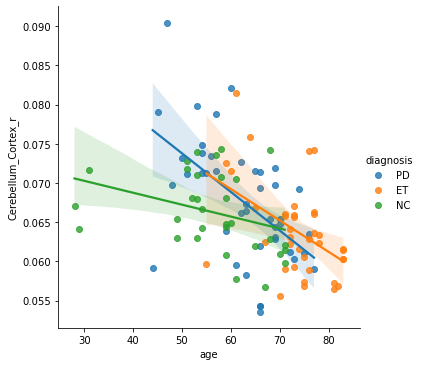

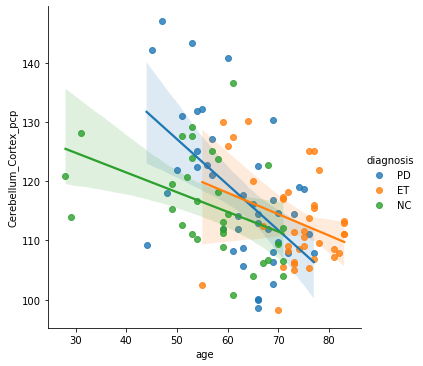

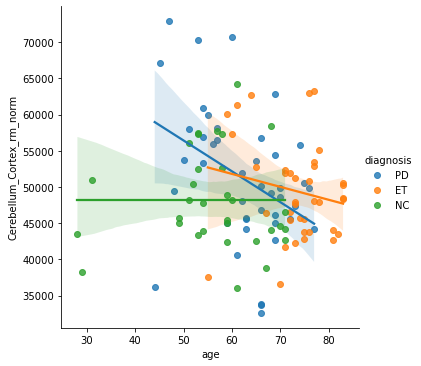

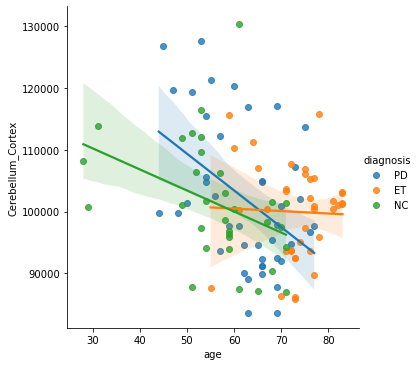

In [15]:
import seaborn as sns
sns.lmplot(data=curr_data, x="age", y='Cerebellum_Cortex_r', hue="diagnosis")
sns.lmplot(data=curr_data, x="age", y='Cerebellum_Cortex_pcp', hue="diagnosis")
sns.lmplot(data=curr_data, x="age", y='Cerebellum_Cortex_rm_norm', hue="diagnosis")
sns.lmplot(data=curr_data, x="age", y='Cerebellum_Cortex', hue="diagnosis")

/usr/local/miniconda/lib/python3.7/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


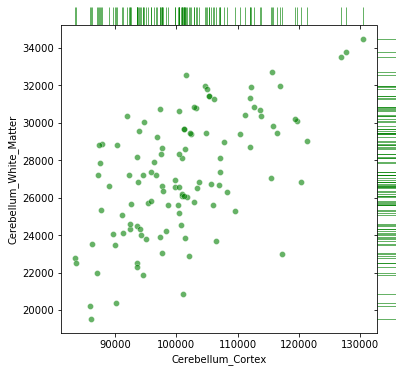

In [16]:
#distribution
g = sns.JointGrid(data=tab_data, x="Cerebellum_Cortex", y="Cerebellum_White_Matter", space=0, ratio=17)
g.plot_joint(sns.scatterplot,
             color="g", alpha=.6, legend=False)
g.plot_marginals(sns.rugplot, height=1, color="g",alpha=.6)
                 